In [1]:
# -------------------------
# Projet UA3 : NO2 autour des écoles d'Île-de-France
# Analyse + visualisation géospatiale
# -------------------------

import os
import pandas as pd
import numpy as np
import plotly.express as px

# -------------------------
# 1. Chargement des données
# -------------------------

# Adapter le chemin si besoin
CSV_PATH = "NO2_hors_Paris.csv"

df = pd.read_csv(CSV_PATH)

print("Aperçu du dataset :")
display(df.head())

print("\nInfo sur les colonnes :")
print(df.dtypes)

print("\nNombre de lignes :", len(df))
print("Années disponibles :", df["Année"].unique())


Aperçu du dataset :


,departement,X,Y,Année,Valeur
0,75,2.290811,48.842157,2012,41.316912
1,75,2.405807,48.875666,2012,63.683878
2,75,2.332706,48.866140,2012,41.507336
3,75,2.347347,48.866889,2012,45.197342
4,75,2.364801,48.856970,2012,40.109546



Info sur les colonnes :
departement      int64
X              float64
Y              float64
Année            int64
Valeur         float64
dtype: object

Nombre de lignes : 75180
Années disponibles : [2012 2013 2014 2015 2016 2017]


In [3]:
# -------------------------
# 2. Vérification de la qualité des données
# -------------------------

print("Valeurs manquantes par colonne :")
print(df.isna().sum())

# On enlève les lignes où X, Y ou Valeur sont manquants (s'il y en a)
df = df.dropna(subset=["X", "Y", "Valeur"])

print("\nTaille du dataset après suppression des valeurs manquantes :", df.shape)

# On s'assure que les types sont corrects
df["Année"] = df["Année"].astype(int)
df["Valeur"] = df["Valeur"].astype(float)

print("\nRésumé statistique de la pollution NO2 :")
display(df["Valeur"].describe())


Valeurs manquantes par colonne :
departement    0
X              0
Y              0
Année          0
Valeur         0
dtype: int64

Taille du dataset après suppression des valeurs manquantes : (75180, 5)

Résumé statistique de la pollution NO2 :


count    75180.000000
mean        28.311618
std         10.193551
min          2.114619
25%         21.747601
50%         28.052457
75%         34.734763
max        110.617037
Name: Valeur, dtype: float64

In [7]:
# ------------------------------------------------------------
# 3. CALCUL DU POINT CENTRAL & ATTRIBUTION DES ZONES
# ------------------------------------------------------------

# Liste des écoles uniques (1 point = 1 école)
ecoles = df[["X", "Y"]].drop_duplicates().reset_index(drop=True)

# Calcul du point central
X_mean = ecoles["X"].mean()
Y_mean = ecoles["Y"].mean()

print(f"Point central : X_mean={X_mean}, Y_mean={Y_mean}")

# Fonction d'attribution des zones géographiques
def attribuer_zone(row, xm, ym):
    if row["X"] > xm and row["Y"] > ym:
        return "NE"  # Nord-Est
    elif row["X"] < xm and row["Y"] > ym:
        return "NO"  # Nord-Ouest
    elif row["X"] < xm and row["Y"] < ym:
        return "SO"  # Sud-Ouest
    elif row["X"] > xm and row["Y"] < ym:
        return "SE"  # Sud-Est
    else:
        return "CENTRE"  # cas rare, exactement sur le centre

# Application de la fonction
df["zone"] = df.apply(lambda r: attribuer_zone(r, X_mean, Y_mean), axis=1)

print("\nRépartition des écoles par zone :")
print(df["zone"].value_counts())

# ------------------------------------------------------------
# Couleurs définies selon la consigne du projet
# ------------------------------------------------------------

color_map = {
    "NE": "blue",   # Nord-Est → Bleu
    "NO": "red",    # Nord-Ouest → Rouge
    "SO": "black",  # Sud-Ouest → Noir
    "SE": "green"   # Sud-Est → Vert
}

print("\nCouleurs associées à chaque zone (comme demandé) :")
print(color_map)


Point central : X_mean=2.3526984503577166, Y_mean=48.829145793341624

Répartition des écoles par zone :
zone
NO    24006
NE    21768
SE    15762
SO    13644
Name: count, dtype: int64

Couleurs associées à chaque zone (comme demandé) :
{'NE': 'blue', 'NO': 'red', 'SO': 'black', 'SE': 'green'}


In [9]:
# ------------------------------------------------------------
# 4. SELECTION ALEATOIRE D’UN ÉCHANTILLON D’ÉCOLES
# ------------------------------------------------------------

# Nombre d'écoles souhaitées
N_ECOLES = 40  
RANDOM_STATE = 42  # pour que l'échantillon soit reproductible

# On sélectionne 40 écoles (points uniques X,Y)
ecoles_uniques = df[["X", "Y"]].drop_duplicates()
ecoles_sample = ecoles_uniques.sample(n=N_ECOLES, random_state=RANDOM_STATE)

print(f"Nombre d'écoles sélectionnées : {len(ecoles_sample)}")
display(ecoles_sample.head())

# On récupère toutes les années de données pour ces écoles sélectionnées
sample = df.merge(ecoles_sample, on=["X", "Y"], how="inner")

print("\nTaille de l'échantillon (toutes années confondues) :", sample.shape)
display(sample.head())

# Préparation finale : une ligne = une école pour une année
sample_agg = (
    sample.groupby(["X", "Y", "Année", "zone"], as_index=False)["Valeur"]
          .mean()
)

print("\nAperçu de l'échantillon agrégé pour visualisation :")
display(sample_agg.head())


Nombre d'écoles sélectionnées : 40


,X,Y
11828,2.468080,48.787635
6419,2.578158,48.860811
3302,1.991096,48.782113
6009,2.242716,48.900192
1451,3.131275,48.477573



Taille de l'échantillon (toutes années confondues) : (282, 6)


,departement,X,Y,Année,Valeur,zone
0,75,2.314954,48.834244,2012,36.481911,NO
1,75,2.364765,48.878343,2012,41.184653,NE
2,75,2.307602,48.828288,2012,37.661108,SO
3,75,2.307602,48.828288,2012,37.661108,SO
4,75,2.370046,48.861250,2012,40.028022,NE



Aperçu de l'échantillon agrégé pour visualisation :


,X,Y,Année,zone,Valeur
0,1.594239,49.07501,2012,NO,17.870210
1,1.594239,49.07501,2013,NO,15.249737
2,1.594239,49.07501,2014,NO,15.898690
3,1.594239,49.07501,2015,NO,14.793239
4,1.594239,49.07501,2016,NO,14.968222


Nombre d'écoles affichées pour l'année 2012 : 40


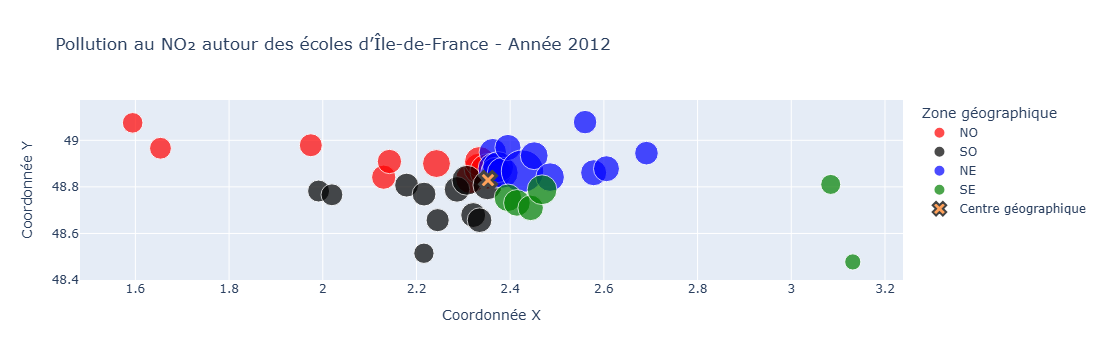

In [13]:
# ------------------------------------------------------------
# 5. CREATION DU VISUEL PRINCIPAL (UNE ANNEE)
# ------------------------------------------------------------

import plotly.express as px

# Choisir l'année à afficher (par exemple 2012)
annee_selectionnee = 2012

# On filtre l'échantillon pour cette année
data_year = sample_agg[sample_agg["Année"] == annee_selectionnee]

print(f"Nombre d'écoles affichées pour l'année {annee_selectionnee} :", len(data_year))

# Création du nuage de points
fig = px.scatter(
    data_year,
    x="X",
    y="Y",
    color="zone",              # code couleur selon la zone
    size="Valeur",             # taille du cercle = niveau de NO2
    size_max=30,               # diamètre max des cercles
    color_discrete_map=color_map,  # couleurs NE/NO/SO/SE
    hover_data={
        "Valeur": True,
        "zone": True,
        "Année": False,
        "X": False,
        "Y": False
    },
    title=f"Pollution au NO₂ autour des écoles d’Île-de-France - Année {annee_selectionnee}"
)

# Ajout du point central (repère visuel)
fig.add_scatter(
    x=[X_mean],
    y=[Y_mean],
    mode="markers",
    marker=dict(
        size=15,
        symbol="x",         # croix
        line=dict(width=3)
    ),
    name="Centre géographique"
)

# Mise en forme des axes et de la légende
fig.update_layout(
    xaxis_title="Coordonnée X",
    yaxis_title="Coordonnée Y",
    legend_title="Zone géographique"
)

fig.show()


Années disponibles dans l'échantillon : [2012, 2013, 2014, 2015, 2016, 2017]


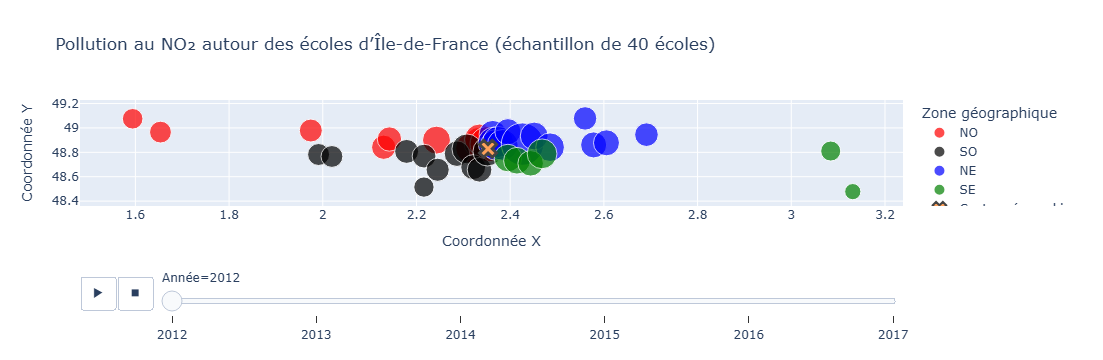

In [15]:
# ------------------------------------------------------------
# 6. DIMENSION TEMPORELLE : SLIDER D'ANNEES
# ------------------------------------------------------------

import plotly.express as px

# Vérification rapide
print("Années disponibles dans l'échantillon :", sorted(sample_agg["Année"].unique()))

# Création de la figure interactive avec animation par année
fig = px.scatter(
    sample_agg,
    x="X",
    y="Y",
    color="zone",                  # couleur = zone géographique
    size="Valeur",                 # taille du cercle = niveau de NO2
    size_max=30,                   # diamètre max des cercles
    animation_frame="Année",       # slider d'années
    color_discrete_map=color_map,  # couleurs NE/NO/SO/SE
    hover_data={
        "Valeur": True,
        "zone": True,
        "Année": True,
        "X": False,
        "Y": False
    },
    title="Pollution au NO₂ autour des écoles d’Île-de-France (échantillon de 40 écoles)"
)

# Ajout du point central (même pour toutes les années)
fig.add_scatter(
    x=[X_mean],
    y=[Y_mean],
    mode="markers",
    marker=dict(
        size=15,
        symbol="x",
        line=dict(width=3)
    ),
    name="Centre géographique"
)

# Mise en forme générale
fig.update_layout(
    xaxis_title="Coordonnée X",
    yaxis_title="Coordonnée Y",
    legend_title="Zone géographique"
)

fig.show()
